In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.callbacks import ModelCheckpoint # new!
import os # new!
import time

2025-04-27 13:36:40.627492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745786200.657999  704353 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745786200.667660  704353 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 13:36:40.705957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
batch_size = 10
box_plot_title = 'Memory Estimation Error (MB)'

# 1. Loading training and test datasets

In [3]:
def load_data():
    df = pd.read_csv('tpcds_query_train.csv')
    
    feature_cols = ['TQ', 'TQ COUNT', 'TBSCAN', 'TBSCAN COUNT', 'SORT', 'SORT COUNT',
       'FILTER', 'FILTER COUNT', 'HS JOIN', 'HS JOIN COUNT', 'TEMP',
       'TEMP COUNT', 'GRPBY', 'GRPBY COUNT', 'UNIQUE', 'UNIQUE COUNT']
    
    target_col = ['actual']
    
    X = df[feature_cols]
    y = df[target_col]
    
    print('X.shape: ', X.shape)
    print('y.shape: ', y.shape)
    
    return X.values, y.values

def load_test_data():
    df = pd.read_csv('tpcds_query_test.csv')
    
    feature_cols = ['TQ', 'TQ COUNT', 'TBSCAN', 'TBSCAN COUNT', 'SORT', 'SORT COUNT',
       'FILTER', 'FILTER COUNT', 'HS JOIN', 'HS JOIN COUNT', 'TEMP',
       'TEMP COUNT', 'GRPBY', 'GRPBY COUNT', 'UNIQUE', 'UNIQUE COUNT']
    
    target_cols = ['actual', 'db2']
    
    X = df[feature_cols]
    Y = df[target_cols]
    
    print('df_test shape: ', df.shape)
    
    return X, Y


def cross_validate(model):
    # Load data
    X, y = load_data()
    train_data = X.copy()
    train_targets = y.copy()

    k = 10
    num_val_samples = len(train_data) // k
    all_train_scores = []
    all_scores = []
    
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                             train_data[(i + 1) * num_val_samples:]], axis=0)
        
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                                train_targets[(i + 1) * num_val_samples:]], axis=0)

        model.fit(partial_train_data, partial_train_targets)
    
        train_mse = mean_squared_error(partial_train_targets, model.predict(partial_train_data))
        val_mse = mean_squared_error(val_targets, model.predict(val_data))
    
        all_train_scores.append(train_mse)
        all_scores.append(val_mse)
    
    print('train rmse ', np.sqrt(np.mean(all_train_scores)))
    print('validation rmse ', np.sqrt(np.mean(all_scores)))

# create workloads for the given batch size
def batch(Y, batch_size=10):
    # generate integer values in range [0, number of records -1]
    indices = np.linspace(0, Y.shape[0]-1, Y.shape[0], dtype=int)
    #np.random.seed(42)
    #np.random.shuffle(indices)
    num_batches = int(np.floor(Y.shape[0] / batch_size))
    
    df_batches = pd.DataFrame(columns=Y.columns)
    
    for ibat in range(num_batches):
        start = (ibat * batch_size)
        end = (ibat * batch_size + batch_size) - 1
        
        ibat_Y = Y.loc[indices[start:end], :]
        
        df_batches = df_batches.append(ibat_Y.sum(), ignore_index=True)
        
    return df_batches

# Review this
def rmse(Y):
    cols = Y.columns.values[1:]
    rmse_dict = {}
    
    for col in cols:
        rmse = np.round(np.sqrt(mean_squared_error(Y['actual'].values, Y[col].values)))
        rmse_dict[col] = rmse
    
    return rmse_dict

def mape(Y):
    cols = Y.columns.values[1:]
    mape_dict = {}
    
    for col in cols:
        mape = mean_absolute_percentage_error(Y['actual'].values, Y[col].values) * 100
        mape_dict[col] = mape
    
    return mape_dict


def calculate_residuals(Y):
    first_col = Y.columns[0]
    cols = Y.columns[1:]
    df_residuals = pd.DataFrame(columns=cols)

    for col in cols:
        df_residuals[col] = Y[col] - Y[first_col]
        
    return df_residuals

def box_plot(Y):
    df_residuals = calculate_residuals(Y)
    sns.set_style("whitegrid", {'axes.grid' : False})
    f = plt.figure(figsize=[10,3])
    ax = f.add_subplot(111)
    sns.boxplot(data=df_residuals, ax=ax, showfliers = True, orient="h")
    ax.set_xlabel(xlabel=box_plot_title,fontsize=13)
    #plt.tick_params(axis='x',labeltop='on', labelbottom='on')
    #ax.xaxis.set_ticks_position('both')
    
    f.tight_layout()
    
    plt.savefig('tpcds_query_boxplot.png', dpi=150)

# Ridge

In [4]:
# Load data
X, y = load_data()

ridge = Ridge(random_state=33)
cross_validate(ridge)

ridge.fit(X, y)

X.shape:  (68500, 16)
y.shape:  (68500, 1)
X.shape:  (68500, 16)
y.shape:  (68500, 1)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  331.261055922525
validation rmse  331.36345310305484


Ridge(random_state=33)

# Decision Tree

In [5]:
# Load data
X, y = load_data()

tree = DecisionTreeRegressor(
    max_features=None, random_state=33)

cross_validate(tree)

tree.fit(X, y)

X.shape:  (68500, 16)
y.shape:  (68500, 1)
X.shape:  (68500, 16)
y.shape:  (68500, 1)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  51.54959311527842
validation rmse  58.439945690758904


DecisionTreeRegressor(random_state=33)

# Random Forest

In [6]:
# Load data
X, y = load_data()

forest = RandomForestRegressor(
    n_estimators=10, random_state=33
)

cross_validate(forest)

forest.fit(X, y)

X.shape:  (68500, 16)
y.shape:  (68500, 1)
X.shape:  (68500, 16)
y.shape:  (68500, 1)
Processing fold #0


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Processing fold #1


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Processing fold #2


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Processing fold #3


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Processing fold #4


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Processing fold #5


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Processing fold #6


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Processing fold #7


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Processing fold #8


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Processing fold #9


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


train rmse  52.087327024864386
validation rmse  57.56868364060745


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_estimators=10, random_state=33)

# XGBoost

In [7]:
# Load data
X, y = load_data()

xgb_regressor = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    gpu_id=-1,
    interaction_constraints="",
    learning_rate=0.300000012,
    max_delta_step=0,
    max_depth=3,
    min_child_weight=1,
    missing=float("nan"),
    monotone_constraints="()",
    n_estimators=100,
    num_parallel_tree=1,
    random_state=33,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    subsample=1,
    tree_method="exact",
    validate_parameters=1,
    verbosity=0,
    silent=False,
    nthread=4,
    seed=33,
)

cross_validate(xgb_regressor)

xgb_regressor.fit(X, y)

X.shape:  (68500, 16)
y.shape:  (68500, 1)
X.shape:  (68500, 16)
y.shape:  (68500, 1)
Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4
Processing fold #5
Processing fold #6
Processing fold #7
Processing fold #8
Processing fold #9
train rmse  54.60444385775269
validation rmse  55.48390869122425


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0, gpu_id=-1, grow_policy=None, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=0, max_depth=3, max_leaves=None, min_child_weight=1,
             missing=nan, monotone_constraints='()', multi_strategy=None,
             n_estimators=100, n_jobs=None, ...)

# DNN using Scikit-learn

In [ ]:
dnn_model = MLPRegressor(hidden_layer_sizes=(64,64,32),
                       max_iter = 100,activation = 'relu',
                       solver = 'adam')
cross_validate(dnn_model)

dnn_model.fit(X, y)

X.shape:  (68500, 16)
y.shape:  (68500, 1)
Processing fold #0


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #1


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #2


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #3


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #4


/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/db2inst1/learnedwmp/.venv/lib64/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Processing fold #5


# All Final Models

In [ ]:
X_test, Y_test = load_test_data()

df_test shape:  (17126, 18)


In [ ]:
num_test_workloads = int(X_test.shape[0] / 10)

## Computing Inference Latency

In [ ]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    tree.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

tree_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('tree: ', tree_time, ' μs')

tree:  283.5  μs


In [ ]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    forest.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

forest_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('forest: ', forest_time, ' μs')

forest:  1852.2  μs


In [ ]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    xgb_regressor.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

xgb_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('xgb: ', xgb_time, ' μs')

xgb:  429.9  μs


In [ ]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    ridge.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

ridge_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('ridge: ', ridge_time, ' μs')

ridge:  188.5  μs


In [ ]:
latency_sum = 0

for i in range(X_test.shape[0]):
    test_row = X_test.loc[i].to_numpy().reshape(1, -1)
    time_start = time.time()
    dnn_model.predict(test_row)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

dnn_time = np.round(latency_sum / X_test.shape[0] * batch_size * 1000000, 1)

print('dnn: ', dnn_time, ' μs')

dnn:  302.5  μs


## Generating Predictions

In [ ]:
Y_test['tree'] = tree.predict(X_test.values)
Y_test['forest'] = forest.predict(X_test.values)
Y_test['xgb'] = xgb_regressor.predict(X_test.values)
Y_test['ridge'] = ridge.predict(X_test.values)
Y_test['dnn'] = dnn_model.predict(X_test.values)

# Computing model sizes

In [ ]:
import sys
import pickle

In [ ]:
# size of the ridge model
p = pickle.dumps(ridge)
print('Ridge:', sys.getsizeof(p) / 1024)

# size of the tree model
p = pickle.dumps(tree)
print('Decision Tree:', sys.getsizeof(p) / 1024)

# size of the forest model
p = pickle.dumps(forest)
print('Random Forest:', sys.getsizeof(p) / 1024)

# size of the xgboost model
p = pickle.dumps(xgb_regressor)
print('XGBoost:', sys.getsizeof(p) / 1024)

# size of the dnn model
p = pickle.dumps(dnn_model)
print('DNN:', sys.getsizeof(p) / 1024)

Ridge: 0.576171875
Decision Tree: 1484.7265625
Random Forest: 10827.966796875
XGBoost: 115.4619140625
DNN: 179.0009765625


# Creating Batches

In [ ]:
# creating batches
Y_test_batch = batch(Y_test, batch_size)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
Y_test_batch.head()

,actual,db2,tree,forest,xgb,ridge,dnn
0,4057.872,2026.580,4380.494655,4333.370340,4350.722656,3202.470530,4454.370355
1,5284.180,2835.860,5434.522578,5374.856146,5366.692383,5324.173474,5331.216360
2,4557.424,3561.968,4526.967947,4550.208494,4511.365723,4139.406590,4554.656259
3,2464.324,1270.668,2477.770921,2487.628667,2446.480713,2403.540544,2469.091362
4,2572.612,2133.128,2907.332050,2940.951073,2878.114014,3940.118526,2928.146895


In [ ]:
Y_test_batch = Y_test_batch[['actual', 'db2', 'tree', 'forest', 'xgb', 'ridge', 'dnn']]

In [ ]:
print('Test RMSE')
print(rmse(Y_test_batch))

Test RMSE
{'db2': 1868.0, 'tree': 177.0, 'forest': 174.0, 'xgb': 170.0, 'ridge': 987.0, 'dnn': 172.0}


In [ ]:
print('TEST MAPE')
print(mape(Y_test_batch))

TEST MAPE
{'db2': 32.87873677210109, 'tree': 3.7241014265273424, 'forest': 3.6695393178301776, 'xgb': 3.5945512733794893, 'ridge': 22.242085728007037, 'dnn': 3.7958799957917275}


BOX PLOT


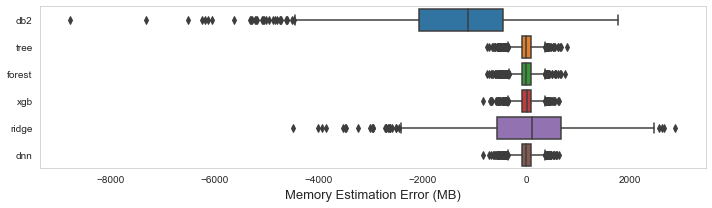

In [ ]:
print('BOX PLOT')
box_plot(Y_test_batch)

In [ ]:
Y_test_batch.shape

(1712, 7)

In [ ]:
Y_test_batch.head()

,actual,db2,tree,forest,xgb,ridge,dnn
0,4057.872,2026.580,4380.494655,4333.370340,4350.722656,3202.470530,4336.172637
1,5284.180,2835.860,5434.522578,5374.856146,5366.692383,5324.173474,5415.822346
2,4557.424,3561.968,4526.967947,4550.208494,4511.365723,4139.406590,4502.430533
3,2464.324,1270.668,2477.770921,2487.628667,2446.480713,2403.540544,2436.472692
4,2572.612,2133.128,2907.332050,2940.951073,2878.114014,3940.118526,2863.468506


# Inter-Quartile Range (IQR)

In [ ]:
residuals = calculate_residuals(Y_test_batch)

In [ ]:
np.percentile(residuals['db2'], [25, 75])

array([-2063.821,  -461.006])

In [ ]:
np.percentile(residuals['ridge'], [25, 75])

array([-571.02871099,  665.18912918])

In [ ]:
np.percentile(residuals['tree'], [25, 75])

array([-83.58191967,  94.49455558])

In [ ]:
np.percentile(residuals['forest'], [25, 75])

array([-83.20569014,  90.70419864])

In [ ]:
np.percentile(residuals['xgb'], [25, 75])

array([-83.36935303,  93.57034033])

In [ ]:
np.percentile(residuals['dnn'], [25, 75])

array([-93.62855298,  85.21639198])

# Training Time

In [ ]:
latency_sum = 0

for i in range(5):
    time_start = time.time()
    ridge.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('ridge training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    tree.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('tree training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    forest.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('forest training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    xgb_regressor.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('xgb training time: ', train_time, ' ms')

latency_sum = 0

for i in range(5):
    time_start = time.time()
    dnn_model.fit(X, y)
    time_end = time.time()
    latency_sum = latency_sum + (time_end - time_start)

train_time = np.round(latency_sum / 5 * 1000, 1)

print('dnn training time: ', train_time, ' ms')

ridge training time:  4.6  ms
tree training time:  142.2  ms


/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_95092/4269665725.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)
/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_95092/4269665725.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)
/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_95092/4269665725.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X, y)
/var/folders/1v/zdszy15n595bb2xxfx_p9bhw0000gn/T/ipykernel_95092/4269665725.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using 

forest training time:  912.4  ms
xgb training time:  975.7  ms


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer:

dnn training time:  37773.8  ms


/Users/shaikhq/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


# exporting residuals

In [ ]:
calculate_residuals(Y_test_batch).to_csv('tpcds-query-residuals.csv')